# **Dickinson GPT**


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

torch.manual_seed(1357)

# Data

In [2]:
with open('/kaggle/input/dickinson-txt/Dickinson.txt','r',encoding='utf-8') as f:
    data = f.read()

# Character Level Tokenizer

In [3]:
class CharacterLevelTokenizer:
    def __init__(self,data):
        self.data = data
        self.vocab = sorted(list(set(self.data)))
        self.VOCAB_SIZE = len(self.vocab)
        
        self.i_s = {i:s for i,s in enumerate(self.vocab)}
        self.s_i = {s:i for i,s in self.i_s.items()}
        
    def encode(self,s):
        return torch.tensor([self.s_i[c] for c in s],dtype=torch.long)

    def decode(self,s):
        return ''.join([self.i_s[i.item()] for i in s])

tokenizer = CharacterLevelTokenizer(data)

# Config

In [4]:
@dataclass
class Config:
    block_size = 256 # context-length
    batch_size = 64 # mini-batch size
    vocab_size = tokenizer.VOCAB_SIZE
    n_embed = 256
    n_heads = 8
    head_size = n_embed // n_heads # computes to 384/6=64 or 128/4=32 or 256/8
    
    n_layers = 3
    
    train_iters = 10_000
    val_iters = 1000
    lr = 3e-4
    
    attn_dropout = 0.1
    block_dropout = 0.1
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
Config.device

'cuda'

# Dataset

In [5]:
class DickinsonDataset:
    def __init__(self,Config, is_test=False) -> None:
        self.tokenizer = CharacterLevelTokenizer(data)
        self.is_test = is_test
        self.full_data = self.tokenizer.encode(self.tokenizer.data)
        if self.is_test:
            self.data = self.full_data[int(0.9*len(self.full_data)):]
        else:
            self.data = self.full_data[:int(0.9*len(self.full_data))]
        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.VOCAB_SIZE

    def get(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x,y

---

# **GPT Model**

## Single Attention Head

In [6]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

## MultiHead Attention

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

## Feed Forward Layer

In [8]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

# Transformer Block

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

## GPT Model

In [10]:
class DickinsonGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

# Training

In [11]:
train_ds = DickinsonDataset(Config)
val_ds = DickinsonDataset(Config,is_test=True)

In [12]:
lm = DickinsonGPT(Config)
lm = lm.to(device=Config.device)

In [13]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

In [14]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

In [15]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = train_ds.get()
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())
        
        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"batch {batch} train step loss: {loss.item()}")
        
        del inputs, targets, loss, logits
        
    return train_step_losses
    
@torch.no_grad()
def valid_N_iters():
    lm.eval()
    val_step_losses = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = val_ds.get()
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())
        
        if batch%(Config.val_iters//10)==0 or batch==Config.val_iters-1:
            print(f"batch {batch} valid step loss: {loss.item()}")
        
        del inputs, targets, loss, logits
    
    return val_step_losses

In [16]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'DickinsonGPT'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'DickinsonGPT.pth'
    torch.save(state_dict, model_path)

In [17]:
def train_lm():
    train_losses = train_N_iters()
    valid_losses = valid_N_iters()
    save_lm()
    return train_losses, valid_losses

In [18]:
tl,vl=train_lm()

  0%|          | 0/10000 [00:00<?, ?it/s]

batch 0 train step loss: 4.773275852203369
batch 1000 train step loss: 2.322897434234619
batch 2000 train step loss: 2.261115789413452
batch 3000 train step loss: 2.271655559539795
batch 4000 train step loss: 1.9157845973968506
batch 5000 train step loss: 1.7401502132415771
batch 6000 train step loss: 1.7795273065567017
batch 7000 train step loss: 1.6540299654006958
batch 8000 train step loss: 1.6011879444122314
batch 9000 train step loss: 1.5723822116851807
batch 9999 train step loss: 1.5659034252166748


  0%|          | 0/1000 [00:00<?, ?it/s]

batch 0 valid step loss: 2.155241012573242
batch 100 valid step loss: 2.1836023330688477
batch 200 valid step loss: 2.3110873699188232
batch 300 valid step loss: 2.171949863433838
batch 400 valid step loss: 2.1635982990264893
batch 500 valid step loss: 2.164520740509033
batch 600 valid step loss: 2.1823601722717285
batch 700 valid step loss: 2.269902467727661
batch 800 valid step loss: 2.198073148727417
batch 900 valid step loss: 2.1979222297668457
batch 999 valid step loss: 2.1911630630493164


# Loss Plots

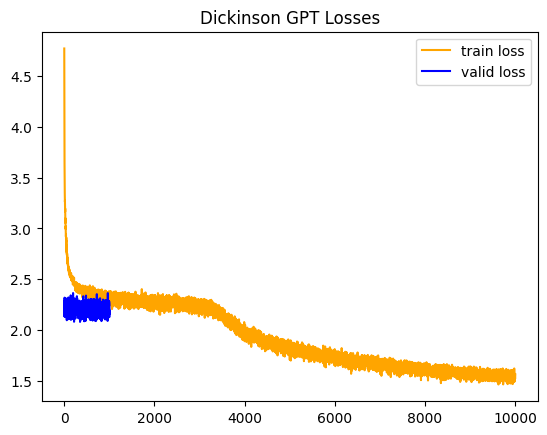

In [19]:
plt.plot(tl,label='train loss',color='orange')
plt.plot(vl,label='valid loss',color='blue')
plt.title('Dickinson GPT Losses')
plt.legend()
plt.show()

# Generating

In [20]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device), # initial context 0
    total=length
)
    generated = tokenizer.decode(generated[0])
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)

Two long
Too go.
The life's ense moone;
And Surior plate,
I advad, with furty
We mould summerititure


generated (300 tokens)

Mors STOORM SACNEBER.

IVED.
MY DYEL-by DON
*

Prides upon thems hat to less,
The feel his thress frerit,
My bee, waiting deat
All the such what sibly.
But of a befortal her flys
A livid how the somet they sun.
No mighbodie, gold noones
With one before readimocitaked
Whose hurringles butter ouch a t


generated (500 tokens)

Had common cannet gun.
THE MORTING COF Our leather when myse this live sunder,
On hone that I the such is day
With then placture
To parading use windeasureeing their him!
But did;
It we to ready smage oncth
Ajostled my for beyonder
Con so I sunred scalls in my stain guilage, of will,
The ranking, by but men emed to spong.

V.
Oh, whell the CHANTROOK, ''T is 'cloor, all rest play, shumbly trand eason.
The was just seen, stoes long
Had;
The one of the betweep as moors a sided buld glast,
To saven 


generated (700 toke

In [21]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)